---
---
---

## Using HypoPredict Module

In [ ]:
from hypopredict import train_test_split

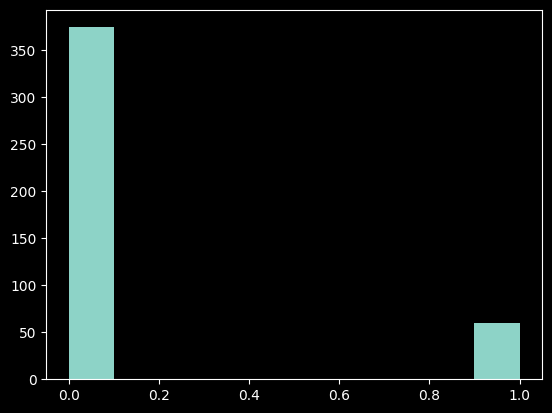

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Convert Google Drive link to direct download format
file_id = '1URua1BRmcTgkwU1nGPWRkrxhabWVotxH'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
df_tochunk = pd.read_feather(url) # ecg

# larger chunks => more context for model to learn from
CHUNK_SIZE = 60 * 60 * 250  # 60 minutes in number of samples

# larger step size => less overlap between chunks => less data + less overfitting
STEP_SIZE = 60*250  # 60 seconds in number of samples
# its ECG data so a 60 second slide is pretty large

chunks = train_test_split.chunkify(df_tochunk, CHUNK_SIZE, STEP_SIZE)

file_id = '1qGfSIb9EEJ4ZxlWnBcsILgh9LbHAiMld'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
gl_d1 = pd.read_feather(url) # glucose same person, all days

onset_times = train_test_split.get_HG_onset_times(gl_d1.loc['2014-10-04'], threshold=3.9)


# predict HG onset in the next 30 mins
FORECAST_WINDOW = pd.Timedelta(minutes=30)

target_labels = train_test_split.generate_target_labels(chunks,
                                        onset_times=onset_times,
                                        forecast_window=FORECAST_WINDOW)

plt.hist(target_labels);

In [ ]:
SAMPLING_RATE = 250  # Hz
TEST_SIZE = 0.2  # 20% for testing

X_train, X_test, y_train, y_test = train_test_split.train_test_split_chunks(
    chunks,
    chunk_size=CHUNK_SIZE,
    step_size=STEP_SIZE,
    target_labels=target_labels,
    forecast_window=FORECAST_WINDOW,
    sampling_rate=SAMPLING_RATE,
    test_size=TEST_SIZE,
)

In [ ]:
len(X_train)

256

In [ ]:
len(y_train)

256

---
---
---

### Loading the day 1 data

In [14]:
#########################
# read all files from get_familiar
# save them in a dictionary of datasets

import pandas as pd
import os

data_dir = 'd1_get_familiar/data/get_familiar'
datasets = {}
for file in os.listdir(data_dir):
    if file.endswith('.feather'):
        dataset_name = file[:file.index('_person')]
        datasets[dataset_name] = pd.read_feather(os.path.join(data_dir, file))


FileNotFoundError: [Errno 2] No such file or directory: 'd1_get_familiar/data/get_familiar'

In [ ]:
# the names of the datasets
print(datasets.keys(), '\n')
# check the sizes of datasets
total_size = 0
for name, df in datasets.items():
    size = df.memory_usage(deep=True).sum()
    total_size += size
    print(f"Dataset '{name}' size: {size / (1024 ** 2):.2f} MB")
print(f"\nTotal size of all datasets: {total_size / (1024 ** 2):.2f} MB")


dict_keys(['breathing', 'accel', 'glucose', 'ecg', 'summary', 'insulin']) 

Dataset 'breathing' size: 9.91 MB
Dataset 'accel' size: 79.30 MB
Dataset 'glucose' size: 0.09 MB
Dataset 'ecg' size: 61.95 MB
Dataset 'summary' size: 6.94 MB
Dataset 'insulin' size: 0.00 MB

Total size of all datasets: 158.19 MB


So it's ~150MB for 1 person for 1 day

=> we have (9 ppl) x (~5 days) x (150MB) = __6.5 GB__ of data JUST from D1namo

=> Gonna practice and develop on small chunks from different dataset,

then add more and more data

In [4]:
9*5*150/1024

6.591796875

In [ ]:
# measured every 4 microseconds
print(datasets['ecg'].info())
datasets['ecg']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6496000 entries, 2014-10-04 06:34:57.423000 to 2014-10-04 13:48:01.419000
Data columns (total 1 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   EcgWaveform  uint16
dtypes: uint16(1)
memory usage: 62.0 MB
None


,EcgWaveform
datetime,
2014-10-04 06:34:57.423,297
2014-10-04 06:34:57.427,297
2014-10-04 06:34:57.431,297
2014-10-04 06:34:57.435,297
2014-10-04 06:34:57.439,297
...,...
2014-10-04 13:48:01.403,1956
2014-10-04 13:48:01.407,1956
2014-10-04 13:48:01.411,1957


In [ ]:
# measured every 5 minutes from day 1 until day 6
# cgm = continuous glucose monitor
print(datasets['glucose'].info())
datasets['glucose']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1438 entries, 2014-10-01 19:14:00 to 2014-10-06 16:54:02
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   glucose  1438 non-null   float64
 1   type     1438 non-null   object 
dtypes: float64(1), object(1)
memory usage: 33.7+ KB
None


,glucose,type
datetime,,
2014-10-01 19:14:00,10.3,cgm
2014-10-01 19:19:00,9.9,cgm
2014-10-01 19:23:00,9.4,manual
2014-10-01 19:24:00,9.8,cgm
2014-10-01 19:29:00,9.6,cgm
...,...,...
2014-10-06 16:34:02,12.3,cgm
2014-10-06 16:39:02,12.5,cgm
2014-10-06 16:44:02,12.5,cgm


In [ ]:
# lots of aggregated measures including SKIN TEMP, HRV, etc.
# measured every 1 second for ONE DAY

print(datasets['summary'].info())
datasets['summary']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25984 entries, 2014-10-04 06:34:57.423000 to 2014-10-04 13:48:00.423000
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HR                25984 non-null  int64  
 1   BR                25984 non-null  float64
 2   SkinTemp          25984 non-null  float64
 3   Posture           25984 non-null  int64  
 4   Activity          25984 non-null  float64
 5   PeakAccel         25984 non-null  float64
 6   BatteryVolts      25984 non-null  float64
 7   BatteryLevel      25984 non-null  int64  
 8   BRAmplitude       25984 non-null  float64
 9   BRNoise           25984 non-null  float64
 10  BRConfidence      25984 non-null  int64  
 11  ECGAmplitude      25984 non-null  float64
 12  ECGNoise          25984 non-null  float64
 13  HRConfidence      25984 non-null  int64  
 14  HRV               25984 non-null  int64  
 15  SystemConfidence  25984 non-null  int6

,HR,BR,SkinTemp,Posture,Activity,PeakAccel,BatteryVolts,BatteryLevel,BRAmplitude,BRNoise,...,SagittalPeak,DeviceTemp,StatusInfo,LinkQuality,RSSI,TxPower,CoreTemp,AuxADC1,AuxADC2,AuxADC3
datetime,,,,,,,,,,,,,,,,,,,,,
2014-10-04 06:34:57.423,65,8.1,-3276.8,-61,0.60,1.46,4.166,94,6046.0,65535.0,...,1.31,27.1,528,255,-128,-128,6553.5,414,422,484
2014-10-04 06:34:58.423,65,8.1,-3276.8,-49,0.54,0.92,4.166,94,5350.0,65535.0,...,0.93,27.1,528,255,-128,-128,6553.5,415,423,483
2014-10-04 06:34:59.423,65,7.3,-3276.8,-22,0.68,1.09,4.166,94,4673.0,65535.0,...,0.24,27.1,528,255,-128,-128,6553.5,425,431,485
2014-10-04 06:35:00.423,65,7.3,-3276.8,22,0.39,0.56,4.166,94,4025.0,65535.0,...,-0.24,27.1,528,255,-128,-128,6553.5,416,423,483
2014-10-04 06:35:01.423,65,6.6,-3276.8,27,0.35,0.86,4.166,94,3500.0,65535.0,...,-0.06,27.1,528,255,-128,-128,6553.5,412,419,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-04 13:47:56.423,0,18.4,-3276.8,-7,0.07,0.10,3.888,48,67.0,65535.0,...,0.22,32.4,531,255,-128,-128,35.3,409,419,461
2014-10-04 13:47:57.423,0,17.7,-3276.8,-7,0.07,0.08,3.888,48,60.0,65535.0,...,0.12,32.4,531,255,-128,-128,35.3,414,420,483
2014-10-04 13:47:58.423,0,17.7,-3276.8,-7,0.05,0.08,3.888,48,53.0,65535.0,...,0.12,32.4,531,255,-128,-128,35.3,419,424,486


---
---
---


## Creating the Train-Test Splitter Module

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Convert Google Drive link to direct download format
file_id = '1URua1BRmcTgkwU1nGPWRkrxhabWVotxH'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
df_tochunk = pd.read_feather(url) # ecg

In [5]:
df_tochunk.head()

,EcgWaveform
datetime,
2014-10-04 06:34:57.423,297
2014-10-04 06:34:57.427,297
2014-10-04 06:34:57.431,297
2014-10-04 06:34:57.435,297
2014-10-04 06:34:57.439,297


In [6]:
file_id = '1qGfSIb9EEJ4ZxlWnBcsILgh9LbHAiMld'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
gl_d1 = pd.read_feather(url) # glucose same person, all days

In [7]:
gl_d1.head()

,glucose,type
datetime,,
2014-10-01 19:14:00,10.3,cgm
2014-10-01 19:19:00,9.9,cgm
2014-10-01 19:23:00,9.4,manual
2014-10-01 19:24:00,9.8,cgm
2014-10-01 19:29:00,9.6,cgm


In [8]:
gl_d1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1438 entries, 2014-10-01 19:14:00 to 2014-10-06 16:54:02
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   glucose  1438 non-null   float64
 1   type     1438 non-null   object 
dtypes: float64(1), object(1)
memory usage: 33.7+ KB


In [9]:
# split sensor data into overlapping chunks of CHUNK_SIZE every STEP_SIZE seconds


def chunkify(df: pd.DataFrame, chunk_size: int, step_size: int) -> list[pd.DataFrame]:
    """
    Function that splits sensor df (ECG, Breathing, Acceleration)
    into overlapping chunks to generate X_train.

    Args:
        df: pd.DataFrame - dataframe with sensor data
        chunk_size: int - size of each chunk in number of samples
        step_size: int - step size in number of samples
    Returns:
        list of pd.DataFrame - list of overlapping chunks
    """

    chunks = []

    # take the starting index from 0 to the end of the dataframe with step size slide
    for start in range(0, df.shape[0], step_size):
        end = start + chunk_size  # ending index of the chunk

        # if the end index is within the dataframe, take the slice as chunk
        if end < df.shape[0]:
            chunk = df.iloc[start:end]
        # otherwise, take the slice from start to the end of the dataframe
        else:
            chunk = df.iloc[start:]

        chunks.append(chunk)  # for each start index, append the chunk to the list

    return chunks

In [ ]:
# larger chunks => more context for model to learn from
CHUNK_SIZE = 60 * 60 * 250  # 60 minutes in number of samples

# larger step size => less overlap between chunks => less data + less overfitting
STEP_SIZE = 60*250  # 60 seconds in number of samples
# its ECG data so a 60 second slide is pretty large

chunks = chunkify(df_tochunk, CHUNK_SIZE, STEP_SIZE)

In [11]:
len(chunks)

434

In [12]:
chunks[0]

,EcgWaveform
datetime,
2014-10-04 06:34:57.423,297
2014-10-04 06:34:57.427,297
2014-10-04 06:34:57.431,297
2014-10-04 06:34:57.435,297
2014-10-04 06:34:57.439,297
...,...
2014-10-04 07:34:57.403,2052
2014-10-04 07:34:57.407,2051
2014-10-04 07:34:57.411,2050


In [13]:
chunks[1]

,EcgWaveform
datetime,
2014-10-04 06:35:57.423,2099
2014-10-04 06:35:57.427,2099
2014-10-04 06:35:57.431,2099
2014-10-04 06:35:57.435,2099
2014-10-04 06:35:57.439,2098
...,...
2014-10-04 07:35:57.403,2040
2014-10-04 07:35:57.407,2038
2014-10-04 07:35:57.411,2037


In [14]:
pd.set_option('display.max_rows', 122)
gl_d1[gl_d1['glucose'] < 3.9]


,glucose,type
datetime,,
2014-10-03 03:54:00,3.8,cgm
2014-10-03 03:59:00,3.6,cgm
2014-10-03 04:04:00,3.5,cgm
2014-10-03 04:09:00,3.4,cgm
2014-10-03 04:14:00,3.2,cgm
2014-10-03 04:19:00,3.1,cgm
2014-10-03 04:24:00,3.0,cgm
2014-10-03 04:29:00,2.9,cgm
2014-10-03 04:34:00,2.8,cgm


In [15]:
###### getting HG onset times ######

# reafctor into function that tales gl_d1 and threshold as input
def get_HG_onset_times(glucose_df: pd.DataFrame, threshold: float = 3.9) -> list:
    """
    Function that gets the onset times of hypoglycemia events
    from the glucose dataframe.

    Args:
        glucose_df: pd.DataFrame - dataframe with glucose data
                    Should have 'glucose' column and datetime index

        threshold: float - glucose threshold for hypoglycemia

    Returns:
        list of pd.Timestamp - list of onset times
    """

    times = glucose_df[glucose_df['glucose'] <= threshold].index
    #times = pd.to_datetime(times, format='%Y-%m-%d %H:%M:%S:%f')

    times_onset = []
    prev_time = None

    for time in times:
        # Check if this time is at least 5 minutes after the last recorded onset
        # that means it's a new onset
        if prev_time is None or (time - prev_time) > pd.Timedelta(minutes=6):
            times_onset.append(time)
        prev_time = time

    return times_onset

In [16]:
get_HG_onset_times(gl_d1, threshold=3.9)

[Timestamp('2014-10-03 03:49:00'),
 Timestamp('2014-10-04 09:15:00'),
 Timestamp('2014-10-04 11:14:01'),
 Timestamp('2014-10-05 09:55:00'),
 Timestamp('2014-10-05 11:24:02'),
 Timestamp('2014-10-06 09:14:02'),
 Timestamp('2014-10-06 12:24:02')]

In [ ]:
# tuple with event number and onset time
# unique across patients

In [21]:
######### Generating target labels #########

# target label is 1 if in the FORECAST WINDOW after the end of the chunk
# there is an onset time

#       1       0       0       0       0
#           |  ot   |       |       |       |
#           |       |       |       |       |
#     chunk1  chunk2  chunk3  chunk4  chunk5

# onset_time: first time glucose < 3.9


# TODO: ongoin



def generate_target_labels(chunks: list[pd.DataFrame],
                           onset_times: list[pd.Timestamp],
                           forecast_window: pd.Timedelta) -> list[int]:
    """
    Function that generates target labels for each chunk based on onset times
    and forecast window. If an onset time falls within the forecast window
    after the end of a chunk, the label for that chunk is 1, otherwise 0.

    Args:
        chunks: list of pd.DataFrame - list of overlapping chunks
                                        Should have index as datetime
        onset_times: list of pd.Timestamp - list of Hypoglycemia onset times
        forecast_window: pd.Timedelta - forecast window duration as timedelta

    Returns:
        list of int - list of target labels (0 or 1) for each chunk
    """

    target_labels = []

    for chunk in chunks:

        chunk_end_time = pd.to_datetime(chunk.index[-1])
        label = 0


        # for each onset time, check if it falls within the forecast window
        # after the end of a given chunk
        for onset_time in onset_times:
            if chunk_end_time < onset_time < chunk_end_time + forecast_window:
                label = 1
                break

        target_labels.append(label)

    # check that the number of labels matches the number of chunks
    assert(len(target_labels) == len(chunks))

    return target_labels

In [22]:
onset_times = get_HG_onset_times(gl_d1.loc['2014-10-04'], threshold=3.9)


In [23]:
onset_times

[Timestamp('2014-10-04 09:15:00'), Timestamp('2014-10-04 11:14:01')]

In [ ]:
# predict HG onset in the next 30 mins
FORECAST_WINDOW = pd.Timedelta(minutes=30)

target_labels = generate_target_labels(chunks,
                                        onset_times=onset_times,
                                        forecast_window=FORECAST_WINDOW)

In [28]:
len(target_labels) == len(chunks)

True

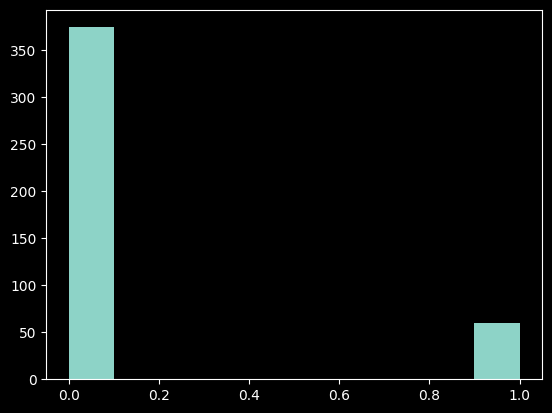

In [29]:
plt.hist(target_labels);

In [30]:
######## Train-Test Split #########

# last date of the last train chunk is t1
# the first date of the first test chunk is t1+FORECAST_WINDOW

def train_test_split_chunks(chunks: list[pd.DataFrame],
                            chunk_size: int,
                            step_size: int,
                            target_labels: list[int],
                            forecast_window: pd.Timedelta,
                            sampling_rate: int = 250,
                            test_size: float = 0.2) -> tuple:
    """
    Function that splits chunks and target labels into train and test sets
    while respecting the forecast window constraint.

    Args:
        chunks: list of pd.DataFrame - list of overlapping chunks
        step_size: int - step size between chunks in samples
        sampling_rate: int - sampling rate of the sensor data in Hz

        target_labels: list of int - list of target labels (0 or 1) for each chunk
        forecast_window: pd.Timedelta - forecast window duration as timedelta
        test_size: float - proportion of the dataset to include in the test split

    Returns:
        tuple - (X_train, X_test, y_train, y_test)
    """

    total_chunks = len(chunks)

    # leave test_size proportion of chunks for testing
    num_test_chunks = int(np.ceil(total_chunks * test_size))

    # take all the last test_size% of chunks and labels as test set
    split_index = total_chunks - num_test_chunks

    X_test = chunks[split_index:]
    y_test = target_labels[split_index:]




    # make sure forecast window is in number of samples using step_size
    forecast_window_freq = int(forecast_window.total_seconds() * sampling_rate)

    # move the last index of the last train chunk to the left
    # by at least forecast_window and chunk_size
    last_train_chunk_index = split_index - np.ceil( (forecast_window_freq + chunk_size) / step_size).astype(int) - 1

    X_train = chunks[:last_train_chunk_index]
    y_train = target_labels[:last_train_chunk_index]


    return X_train, X_test, y_train, y_test

In [31]:
STEP_SIZE

15000

In [32]:
SAMPLING_RATE = 250  # Hz i.e. samples per second

In [33]:
int(FORECAST_WINDOW.total_seconds()*SAMPLING_RATE)

450000

In [34]:
int((np.ceil(FORECAST_WINDOW.total_seconds()*SAMPLING_RATE + CHUNK_SIZE)/STEP_SIZE)) + 1

91

In [35]:
SAMPLING_RATE = 250  # Hz
TEST_SIZE = 0.2  # 20% for testing

X_train, X_test, y_train, y_test = train_test_split_chunks(
    chunks,
    chunk_size=CHUNK_SIZE,
    step_size=STEP_SIZE,
    target_labels=target_labels,
    forecast_window=FORECAST_WINDOW,
    sampling_rate=SAMPLING_RATE,
    test_size=TEST_SIZE,
)

In [36]:
# check if the last X_train index + forecast window < first X_test index
last_X_train_end_time = X_train[-1].index[-1]
first_X_test_start_time = X_test[0].index[0]
last_X_train_end_time + FORECAST_WINDOW < first_X_test_start_time

True

In [37]:
last_X_train_end_time, first_X_test_start_time

(Timestamp('2014-10-04 11:49:57.419000'),
 Timestamp('2014-10-04 12:21:57.423000'))

In [ ]:
# make sure we don't excpose the same HG event in the test set that was in the train set

In [ ]:
####### Feature generation


# generate sin-cos features and time-of-day feature
df_tochunk['time_of_day'] = df_tochunk['datetime'].dt.hour * 3600000 + \
                        df_tochunk['datetime'].dt.minute * 60000 + \
                        df_tochunk['datetime'].dt.second * 1000 + \
                        df_tochunk['datetime'].dt.microsecond / 1000
df_tochunk['time_sin'] = np.sin(2 * np.pi * df_tochunk['time_of_day'] / 86400000)
df_tochunk['time_cos'] = np.cos(2 * np.pi * df_tochunk['time_of_day'] / 86400000)


# generate lagged features for lags from 1s to 60s per 1s (250 to 15000 samples)
lags = range(250, 15001, 250)
for lag in lags:
    df_tochunk[f'lag_{lag}'] = df_tochunk['EcgWaveform'].shift(lag)
    if lag % 1250 == 0:
        print(f'\nGenerated lagged feature for up to {lag/250}s / 60s')


# generate rolling features for window sizes 1s, 5s, 15s, 30s, 60s
window_sizes = [250, 1250, 3750, 7500, 15000]
for window in window_sizes:
    print(f'\nGenerating rolling features for window size {window/250}s')
    df_tochunk[f'rolling_mean_{window}'] = df_tochunk['EcgWaveform'].rolling(window=window).mean()
    df_tochunk[f'rolling_std_{window}'] = df_tochunk['EcgWaveform'].rolling(window=window).std()
    df_tochunk[f'rolling_min_{window}'] = df_tochunk['EcgWaveform'].rolling(window=window).min()
    df_tochunk[f'rolling_max_{window}'] = df_tochunk['EcgWaveform'].rolling(window=window).max()
    # # hearrate variability features
    # df_tochunk[f'rolling_hrv_{window}'] = df_tochunk['EcgWaveform'].rolling(window=window)\
    #                                     .apply(lambda x: np.std(np.diff(x)), raw=True)
    # # heartrate
    # df_tochunk[f'rolling_hr_{window}'] = df_tochunk['EcgWaveform'].rolling(window=window)\
    #         .apply(lambda x: window/250 / np.mean(np.diff(x)) if np.mean(np.diff(x)) != 0 else 0, raw=True)

df_tochunk.dropna(inplace=True)
df_tochunk.drop(columns=['D', 'h', 'm', 's', 'ms'], inplace=True)

print('''
    Dataframe after feature engineering:
    1. Lagged features from 1s to 60s
    2. Rolling features (mean, std, min, max, hrv, hr) for window sizes 1s, 5s, 15s, 30s, 60s
    3. Time-of-day sin-cos features

    Starting chunking process...
      ''')


In [ ]:
###### fitting baseline #######
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import warnings

warnings.filterwarnings("ignore")

val_aucs = []
val_aps = []

for train_slice, val_tuple in train_val_slices:
    # Prepare training data
    X_train_list = []
    y_train_list = []
    for train_chunk, train_label in train_slice:
        X_train_list.append(train_chunk.drop(columns=['datetime']).values)
        y_train_list.append(train_label)

    X_train = np.vstack(X_train_list)
    y_train = np.repeat(y_train_list, [X.shape[0] for X in X_train_list])

    # Prepare validation data
    val_chunk, val_label = val_tuple
    X_val = val_chunk.drop(columns=['datetime']).values
    y_val = np.full(X_val.shape[0], val_label)

    # Standardize features
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_val = scaler.transform(X_val)

    # Train LightGBM
    clf = LGBMClassifier(n_estimators=1111,
                         max_depth=13,
                         max_leaves=2**13,
                         learning_rate=0.1,
                         #reg_lambda=0.1,
                         reg_alpha=0.05,
                         is_unbalanced=True,
                         random_state=17,
                         verbose=-1)
    clf.fit(X_train, y_train)

    # Predict on validation set
    y_pred_proba = clf.predict_proba(X_val)[:, 1]

    # Calculate precision-recall AUC and average precision
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)
    ap = average_precision_score(y_val, y_pred_proba)

    val_aucs.append(pr_auc)
    val_aps.append(ap)

print(f"Mean PR-AUC: {np.mean(val_aucs):.4f} (+/- {1.96*np.std(val_aucs)/np.sqrt(len(val_aucs)):.4f})")
print(f"Mean AP: {np.mean(val_aps):.4f} (+/- {1.96*np.std(val_aps)/np.sqrt(len(val_aps)):.4f})")